
# 📘 Coffee Recommender Comparison — TF‑IDF vs Word2Vec

This notebook builds **two hybrid recommender models** on the dataset:

1. **TF‑IDF + numeric features**  
2. **Word2Vec + numeric features**

Both models combine similarity from six sensory attributes:

- Agtron
- Aroma
- Acid
- Body
- Flavor
- Aftertaste

with textual similarity derived from the coffee descriptions.


In [31]:

import pandas as pd
import numpy as np
import re, os, sys
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import gensim.downloader as api
from gensim.utils import simple_preprocess
import matplotlib.pyplot as plt


In [54]:
pd.set_option('display.max_colwidth', 50)

# === 1. Load dataset ===
df = pd.read_csv('datasets\coffee_df_with_type_and_region.csv')
print(f"Loaded {len(df):,} rows")
df.head()

Loaded 2,282 rows


<>:4: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\c'
C:\Users\aklem\AppData\Local\Temp\ipykernel_5536\2578853630.py:4: SyntaxWarning: invalid escape sequence '\c'
  df = pd.read_csv('datasets\coffee_df_with_type_and_region.csv')


,slug,all_text,rating,roaster,name,region_africa_arabia,region_caribbean,region_central_america,region_hawaii,region_asia_pacific,...,agtron,aroma,acid,body,flavor,aftertaste,with_milk,desc_1,desc_2,desc_3
0,https://www.coffeereview.com/review/wilton-ben...,\r\n\r\n\r\n95\r\n\r\n\r\nJBC Coffee Roasters...,95,JBC Coffee Roasters,Wilton Benitez Geisha,0,0,0,0,0,...,59/81,9.0,9.0,9.0,9.0,9.0,NaN,"Richly floral-toned, exceptionally sweet. Dist...",Produced by Wilton Benitez of Macarena Farm en...,"A nuanced, complex experimentally processed Co..."
1,https://www.coffeereview.com/review/colombia-c...,\r\n\r\n\r\n95\r\n\r\n\r\nBird Rock Coffee Ro...,95,Bird Rock Coffee Roasters,Colombia Cerro Azul Geisha,0,0,0,0,0,...,62/80,9.0,9.0,9.0,9.0,9.0,NaN,"Richly aromatic, chocolaty, fruit-toned. Dark ...",Produced by Rigoberto Herrera of Granja La Esp...,"A trifecta of fruit, chocolate and flowers, bo..."
2,https://www.coffeereview.com/review/yirgacheff...,\r\n\r\n\r\n94\r\n\r\n\r\nRegent Coffee\r\nYi...,94,Regent Coffee,Yirgacheffe Mengesha Natural,1,0,0,0,0,...,60/77,9.0,9.0,9.0,9.0,8.0,NaN,"High-toned, fruit-driven. Boysenberry, pear, c...",Produced at Mengesha Farm from selections of i...,A fruit medley in a cup — think boysenberry an...
3,https://www.coffeereview.com/review/colombia-t...,\r\n\r\n\r\n93\r\n\r\n\r\nRegent Coffee\r\nCo...,93,Regent Coffee,Colombia Tolima Finca El Mirador Washed Anaerobic,0,0,0,0,0,...,59/79,9.0,9.0,8.0,9.0,8.0,NaN,"Delicately fruit-toned. Guava, ginger blossom,...",Produced by Victor Gutiérrez of Finca Mirador ...,"An appealing washed anaerobic cup: deep-toned,..."
4,https://www.coffeereview.com/review/panama-gei...,\r\n\r\n\r\n94\r\n\r\n\r\nTheory Coffee Roast...,94,Theory Coffee Roasters,Panama Geisha Finca Debra Symbiosis,0,0,1,0,0,...,62/80,9.0,9.0,9.0,9.0,8.0,NaN,"Richly fruit-forward, floral-toned. Lychee, te...",Produced by Jamison Savage of Finca Debra enti...,A floral- and fruit-driven anaerobic natural P...


In [33]:

# === 2. Preprocess ===
FEATURES = ['agtron', 'aroma', 'acid', 'body', 'flavor', 'aftertaste']
DESC_COLS = ['desc_1', 'desc_2', 'desc_3']

def convert_to_float(val):
    """Convert ratio or numeric strings to float."""
    if isinstance(val, str) and '/' in val:
        try:
            num, denom = val.split('/')
            return float(num) / float(denom)
        except Exception:
            return None
    try:
        return float(val)
    except Exception:
        return None

# Convert agtron
df['agtron'] = df['agtron'].apply(convert_to_float)

# Combine text columns
df['full_desc'] = df[DESC_COLS].fillna('').agg(' '.join, axis=1)

def preprocess_description(text: str) -> str:
    text = text.lower().strip()
    patterns_to_remove = [
        r"^i (would like|want|am looking|feel like)( to)?( have| try| taste| get)?( a| some)?",
        r"^i (need|prefer|love|crave)( a| some)?",
        r"^looking for( a| some)?",
    ]
    for pattern in patterns_to_remove:
        text = re.sub(pattern, '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['full_desc'] = df['full_desc'].apply(preprocess_description)

# Drop rows with missing numeric features
before = len(df)
df.dropna(subset=FEATURES, inplace=True)
after = len(df)
print(f'Dropped {before-after} rows due to missing numeric features; remaining: {after}')


Dropped 371 rows due to missing numeric features; remaining: 1911


In [34]:

# Min‑Max scale numeric features to [0,1]
scaler = MinMaxScaler()
df[FEATURES] = scaler.fit_transform(df[FEATURES])


In [35]:

# === 3. Vectorise descriptions with TF‑IDF ===
tfidf = TfidfVectorizer(stop_words='english')
desc_tfidf = tfidf.fit_transform(df['full_desc'])
print("TF‑IDF matrix shape:", desc_tfidf.shape)


TF‑IDF matrix shape: (1911, 6753)


In [36]:

# === 4. Load Word2Vec ===
# Uses gensim downloader to fetch small model (~127 MB) automatically on first run.
W2V_MODEL_NAME = 'glove-wiki-gigaword-100'  # smaller; switch to 'word2vec-google-news-300' if have the disk & time
print(f'Loading...')
w2v = api.load(W2V_MODEL_NAME)  # cached after first download
print("Embedding dimension:", w2v.vector_size)

def get_avg_vector(text: str, model) -> np.ndarray:
    tokens = simple_preprocess(text)
    vecs = [model[t] for t in tokens if t in model]
    if not vecs:
        return np.zeros(model.vector_size)
    return np.mean(vecs, axis=0)

# Pre‑compute coffee description vectors
desc_w2v = np.vstack([get_avg_vector(t, w2v) for t in df['full_desc']])


Loading...
Embedding dimension: 100


In [37]:

# === 5. Define a sample user profile ===
user_prefs = dict(zip(
    FEATURES,
    [0.5, 0.8, 0.6, 0.5, 0.7, 0.4]   # <-- customise here
))
user_text = "I want a fruity coffee with low acidity and medium body"
clean_text = preprocess_description(user_text)

# user_desc = 'fruity coffee with low acidity and medium body'
# user_prefs = {
#     'agtron': 0.50,
#     'aroma': 0.75,
#     'acid': 0.40,
#     'body': 0.60,
#     'flavor': 0.80,
#     'aftertaste': 0.35,
# }


In [38]:

# === 6. Compute similarities ===
# Numeric similarity
coffee_numeric = df[FEATURES].values
user_numeric_vec = np.array([user_prefs[f] for f in FEATURES])
dist = np.linalg.norm(coffee_numeric - user_numeric_vec, axis=1)
numeric_sim = 1 - (dist - dist.min()) / (dist.max() - dist.min())

# TF‑IDF similarity
user_tfidf = tfidf.transform([clean_text])
text_sim_tfidf = cosine_similarity(user_tfidf, desc_tfidf).flatten()

# Word2Vec similarity
user_w2v_vec = get_avg_vector(clean_text, w2v).reshape(1, -1)
text_sim_w2v = cosine_similarity(user_w2v_vec, desc_w2v).flatten()

alpha = 0.5  # weight for numeric vs text
df['sim_tfidf'] = alpha * numeric_sim + (1-alpha) * text_sim_tfidf
df['sim_w2v']  = alpha * numeric_sim + (1-alpha) * text_sim_w2v


In [39]:

# === 7. Show Top‑N recommendations ===
TOP_N = 5
display_cols = ['name', 'roaster', 'desc_1', 'sim_tfidf', 'sim_w2v']

top_tfidf = df.nlargest(TOP_N, 'sim_tfidf')[display_cols]
top_w2v  = df.nlargest(TOP_N, 'sim_w2v')[display_cols]

print("Top‑%d by TF‑IDF + numeric:" % TOP_N)
display(top_tfidf)

print("\nTop‑%d by Word2Vec + numeric:" % TOP_N)
display(top_w2v)

# Compute overlap
overlap = len(set(top_tfidf.index) & set(top_w2v.index)) / TOP_N
print(f"Top‑{TOP_N} overlap: {overlap*100:.1f}%")


Top‑5 by TF‑IDF + numeric:


,name,roaster,desc_1,sim_tfidf,sim_w2v
736,Bolivia Finca El Arcangel,Hidden Coffee HK,"Crisply sweet, delicately aromatic. Hazelnut, date, tiger lily, fresh-cut fir, agave syrup in aroma and cup. Sweet structure with brisk acidity; velvety-smooth mouthfeel. The wood-framed finish is sweetly nut-toned into the long.",0.528152,0.933825
141,Purple Tipsy Night,David's Nose,"Tart-leaning, fruity-sweet. Raspberry, cocoa powder, nasturtium, fir, lemon drop in aroma and cup. Bittersweet structure with tart acidity; full, syrupy mouthfeel. Gently drying, wood-framed finish with raspberry undertones.",0.525175,0.950236
1259,Taiwan Natural Medium Roast,The Formosa Coffee,"Sweet-toned, fruit-centered. Raisin, brown sugar, lemon zest, prairie flowers, oak in aroma and cup. Sweet structure with brisk acidity; medium-bodied, velvety-smooth mouthfeel. The gently drying finish consolidates to notes of brown sugar and oak with hints of lemon zest.",0.521717,0.927179
1789,Natural Burundi Nemba,Amavida Coffee Roasters,"Round, layered, sweet-savory, understated but original. Walnut, cocoa powder, maple syrup, hints of pear and rum in aroma and cup. Softly brisk in structure; syrupy and full in mouthfeel. Flavor consolidates around walnut and maple syrup in a gently drying finish.",0.521235,0.921766
243,Rwanda Karambi Station Natural,RamsHead Coffee Roasters,"Crisply tart, sweetly herbaceous. Tangerine, thyme, tea rose, fresh-cut oak, baking chocolate in aroma and cup. Sweet-tart structure with brisk acidity; satiny-smooth mouthfeel. The citrusy finish leads with notes of tangerine and tea rose.",0.516982,0.899726



Top‑5 by Word2Vec + numeric:


,name,roaster,desc_1,sim_tfidf,sim_w2v
141,Purple Tipsy Night,David's Nose,"Tart-leaning, fruity-sweet. Raspberry, cocoa powder, nasturtium, fir, lemon drop in aroma and cup. Bittersweet structure with tart acidity; full, syrupy mouthfeel. Gently drying, wood-framed finish with raspberry undertones.",0.525175,0.950236
1054,Ecuador La Hormiga “Naty”,Paradise Roasters,"Delicately sweet-tart. Candy apple, green banana, grapefruit zest, brown sugar, marjoram in aroma and cup. Gently sweet structure with pert acidity; viscous, lively mouthfeel. The quiet finish consolidates to notes of tropical and citrus fruits and sweet garden herbs.",0.501931,0.942244
716,Rwanda Abakundakawa,Fresh Roasted Coffee,"Sweet-toned, gently floral. Baking chocolate, honeysuckle, almond, fresh-cut fir, brown sugar in aroma and cup. Sweet structure with brisk acidity; full, velvety mouthfeel. Gently drying, wood-framed finish with undertones of baking chocolate and almond.",0.494775,0.939926
13,Mexico La Peña,SkyTop Coffee,"Crisply sweet, citrusy and bright. Orange zest, baking chocolate, agave syrup, lily, cashew in aroma and cup. Tart-leaning structure with brisk acidity; velvety mouthfeel. The gently drying finish consolidates to suggestions of chocolate and lily.",0.496757,0.939722
1595,Butare Huye of Rwanda,San Francisco Bay Coffee,"Richly sweet, balanced. Orange zest, baking chocolate, black tea, pear, oak in aroma and cup. Sweet-tart in structure with brisk acidity; satiny-smooth mouthfeel. The resonant though tannic finish is carried by notes of baking chocolate and fresh-cut cedar.",0.498035,0.938065


Top‑5 overlap: 20.0%


In [ ]:
# Evaluation metrics for Top-N

import itertools
from sklearn.metrics.pairwise import cosine_similarity

TOP_N = 5  # ubah sesuai kebutuhan

# --- Ambil indeks Top-N masing-masing model ---
top_idx_tfidf = np.argsort(text_sim_tfidf)[::-1][:TOP_N]
top_idx_w2v   = np.argsort(text_sim_w2v)[::-1][:TOP_N]

# 1) Jaccard Overlap
def jaccard(a, b):
    return len(set(a) & set(b)) / len(set(a) | set(b))

jac_overlap = jaccard(top_idx_tfidf, top_idx_w2v)

# 2) Intra-List Diversity (ILD)
#  gunakan matriks cosine similarity antar-item berbasis TF-IDF
tfidf_vec = TfidfVectorizer(stop_words="english")
M_tfidf   = tfidf_vec.fit_transform(df["full_desc"])
global_cos = cosine_similarity(M_tfidf)

def ild(indices, sim_matrix):
    if len(indices) < 2:
        return 0.0
    sims = [
        sim_matrix[i, j] for i, j in itertools.combinations(indices, 2)
    ]
    return 1 - np.mean(sims)

ild_tfidf = ild(top_idx_tfidf, global_cos)
ild_w2v   = ild(top_idx_w2v  , global_cos)


# Tampilkan hasil
print(f"Evaluation (Top-{TOP_N})")
print(f"• Jaccard Overlap            : {jac_overlap:.2f}")
print(f"• ILD  TF-IDF                : {ild_tfidf:.2f}")
print(f"• ILD  Word2Vec              : {ild_w2v:.2f}")

Evaluation (Top-5)
• Jaccard Overlap            : 0.00
• ILD  TF-IDF                : 0.89
• ILD  Word2Vec              : 0.90
• Coverage TF-IDF            : 0.262%
• Coverage Word2Vec          : 0.262%


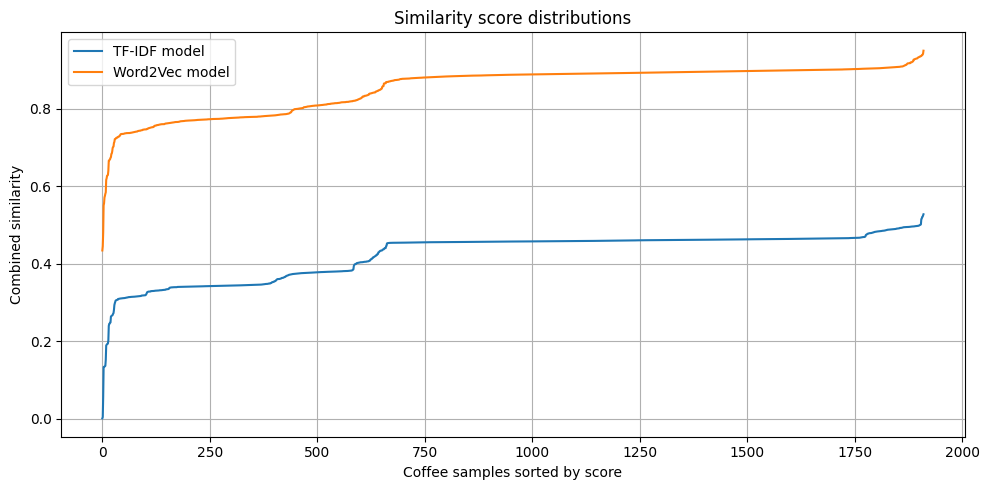

In [41]:

# === 8. Visualise similarity distributions ===
plt.figure(figsize=(10,5))
plt.plot(df['sim_tfidf'].sort_values().values, label='TF‑IDF model')
plt.plot(df['sim_w2v'].sort_values().values, label='Word2Vec model')
plt.title('Similarity score distributions')
plt.xlabel('Coffee samples sorted by score')
plt.ylabel('Combined similarity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Why was the top TF‑IDF coffee recommended?

In [49]:
item_idx = top_idx_tfidf[0] # first recommendation from TF-IDF
item_row = df.iloc[item_idx]
top_terms = tfidf_vec.inverse_transform(M_tfidf[item_idx])[0][:3]
delta = {f: item_row[f] - user_prefs[f] for f in FEATURES}

print('Coffee:', item_row['name'])
print('Top keywords:', ', '.join(top_terms))
print('Full Desc:', item_row['full_desc'])
print('Δ sensory (item - pref):')
for k, v in delta.items():
    print(f' {k:<10s}: {v:+.2f}')


item_idx_w2v = top_idx_w2v[0]  # first recommendation from Word2Vec
item_row_w2v = df.iloc[item_idx_w2v]
top_terms_w2v = tfidf_vec.inverse_transform(M_tfidf[item_idx_w2v])[0][:3]
delta_w2v = {f: item_row_w2v[f] - user_prefs[f] for f in FEATURES}

print('\nCoffee (Word2Vec):', item_row_w2v['name'])
print('Full Desc:', item_row_w2v['full_desc'])
print('Top keywords:', ', '.join(top_terms_w2v))
print('Δ sensory (item - pref):')
for k, v in delta_w2v.items():
    print(f' {k:<10s}: {v:+.2f}')

Coffee: Ethiopia Gera Estate Anaerobic Natural
Top keywords: richly, sweet, aroma
Full Desc: tropically fruity, richly chocolaty. dried blueberry, lychee, chocolate fudge, cedar, wisteria in aroma and cup. brightly sweet-tart structure with winy acidity; plush, very viscous mouthfeel. long, resonant, flavor-saturated finish. produced at gera estate from trees of selections of indigenous landrace varieties of ethiopia arabica, and processed by the natural anaerobic method, wherein whole fruit is fermented with limited oxygen before drying. magnolia coffee is a charlotte-based specialty roaster whose mission is to use sustainably sourced coffees to make a difference in the lives of coffee workers and to foster a socially conscious community with cause-supporting coffees. visit www.magnoliacoffeeco.com for more information. a dessert-like ethiopia anaerobic natural: chocolaty, fruit-driven and deep, evocative of a tropical fruit melange, with vibrant acidity and lush body.
Δ sensory (item